In [48]:
#import libraries
import os
import sys

import numpy as np
import csv
import pandas as pd
from random import shuffle
#import tensorflow as tf
import torch
import torch.optim as optim
import torch.nn as nn
from torchviz import make_dot
from torchvision import models
from torch.nn import init
from torch.autograd import Variable
import torch.nn.functional as F
from torch.utils import data
from torch.optim import lr_scheduler
from torch.utils.data import TensorDataset
from torch.utils.data import Dataset, DataLoader


from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error
from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.model_selection import KFold
from sklearn.metrics import roc_auc_score
from sklearn import preprocessing
from sklearn.metrics import f1_score   
    

from tqdm import tqdm, tqdm_notebook, tnrange
from tqdm.autonotebook import tqdm
import logging

import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
ch = logging.StreamHandler(sys.stdout)

In [3]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'

In [4]:
#importing dataset
dataset = pd.read_csv('model_outputs_patient_level_v1.csv')

In [5]:
#partial view of dataset from top
dataset.head()

,patient_id,bacterial_score,covid_score,normal_score,prediction,target,group
0,R_0dE4arEYyn9VJOV,-0.314141,-0.064040,0.326980,normal,covid,train
1,R_10vi04lh64FGSvp,-3.149383,-0.104033,4.250199,normal,normal,train
2,R_114rz6JiHw1akAz,-4.287257,7.185577,-2.219140,covid,covid,train
3,R_12JQheYe68Gad2a,-0.930601,-0.562607,2.240499,normal,normal,train
4,R_1CwPCqYEGxeiu3r,-3.412590,5.565616,-1.503724,covid,covid,train


In [6]:
#checking for missing values
print(str('Any missing data or NaN in the dataset:'),dataset.isnull().values.any())

Any missing data or NaN in the dataset: False


In [7]:
dataset = dataset[['bacterial_score','covid_score','normal_score','target']]

In [8]:
#partial view of dataset from top
dataset.head()

,bacterial_score,covid_score,normal_score,target
0,-0.314141,-0.064040,0.326980,covid
1,-3.149383,-0.104033,4.250199,normal
2,-4.287257,7.185577,-2.219140,covid
3,-0.930601,-0.562607,2.240499,normal
4,-3.412590,5.565616,-1.503724,covid


                 bacterial_score  covid_score  normal_score
bacterial_score         1.000000    -0.703216     -0.428803
covid_score            -0.703216     1.000000     -0.328531
normal_score           -0.428803    -0.328531      1.000000


<AxesSubplot:>

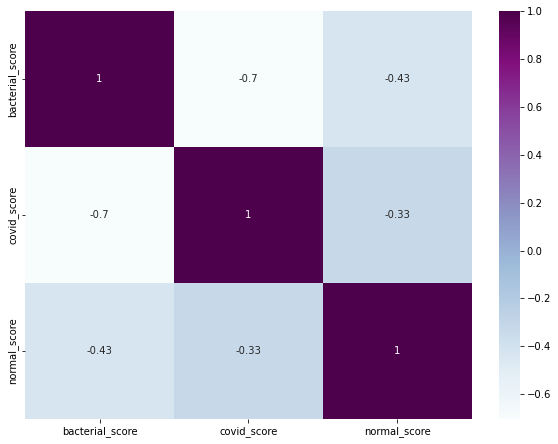

In [9]:
#finding correlation between the features
corr_var=dataset.corr()
print(corr_var)
plt.figure(figsize=(10,7.5))
sns.heatmap(corr_var, annot=True, cmap='BuPu')

In [10]:
#dimension of the dataset
dataset.shape

(126, 4)

In [12]:
X = dataset.iloc[:, 0:-1].values
y = dataset.iloc[:, -1].values

In [13]:
print(X)

[[-3.1414120e-01 -6.4040326e-02  3.2697980e-01]
 [-3.1493835e+00 -1.0403266e-01  4.2501993e+00]
 [-4.2872567e+00  7.1855774e+00 -2.2191403e+00]
 [-9.3060124e-01 -5.6260693e-01  2.2404993e+00]
 [-3.4125898e+00  5.5656160e+00 -1.5037245e+00]
 [-1.1502687e+00 -8.9617735e-01  2.1934068e+00]
 [-3.5938250e+00  6.1282954e+00 -2.0727468e+00]
 [ 3.0500658e+00 -7.6074280e-01 -1.6272633e+00]
 [ 4.7408905e+00 -1.1547126e+00 -3.1440196e+00]
 [-3.1859577e-01 -1.4221884e+00  2.4021032e+00]
 [ 2.9879577e+00 -1.9077753e+00 -7.9448783e-01]
 [ 1.3221179e+00 -4.5873990e-01 -6.7501070e-01]
 [ 5.4516140e-01 -6.2160400e-01  5.1225716e-01]
 [ 2.9751408e+00 -1.7096481e+00 -1.4888082e+00]
 [ 4.2601126e-01 -1.3782760e-01 -2.5847560e-02]
 [ 2.7337341e+00 -1.3899528e+00 -1.3001254e+00]
 [ 1.2680313e-01 -4.9600005e-01  6.4611370e-01]
 [ 2.8943640e+00 -1.2893875e+00 -8.7796736e-01]
 [-1.1878661e+00 -1.0804182e+00  2.8887990e+00]
 [-4.4728380e+00  6.5762170e+00 -1.7032211e+00]
 [-4.1937523e+00  6.3218856e+00 -1.39966

In [14]:
print(y)

['covid' 'normal' 'covid' 'normal' 'covid' 'normal' 'covid' 'bacterial'
 'bacterial' 'normal' 'bacterial' 'covid' 'bacterial' 'bacterial' 'normal'
 'bacterial' 'normal' 'bacterial' 'normal' 'covid' 'covid' 'bacterial'
 'bacterial' 'normal' 'normal' 'normal' 'covid' 'bacterial' 'bacterial'
 'covid' 'covid' 'bacterial' 'normal' 'bacterial' 'bacterial' 'normal'
 'normal' 'covid' 'covid' 'normal' 'normal' 'normal' 'normal' 'normal'
 'normal' 'normal' 'bacterial' 'normal' 'normal' 'normal' 'covid' 'normal'
 'bacterial' 'covid' 'normal' 'normal' 'covid' 'normal' 'normal' 'covid'
 'normal' 'bacterial' 'bacterial' 'bacterial' 'bacterial' 'normal'
 'bacterial' 'bacterial' 'bacterial' 'normal' 'bacterial' 'normal'
 'bacterial' 'normal' 'normal' 'covid' 'normal' 'normal' 'bacterial'
 'bacterial' 'covid' 'covid' 'bacterial' 'bacterial' 'bacterial' 'covid'
 'normal' 'normal' 'covid' 'covid' 'normal' 'covid' 'normal' 'bacterial'
 'covid' 'covid' 'covid' 'normal' 'bacterial' 'normal' 'covid' 'bacteri

In [15]:
#Categorical encoding if we need it in the future
#from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
#Example gender column in index 2 for sample csv
y[:] = le.fit_transform(y[:])

In [16]:
type(y)

numpy.ndarray

In [17]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [18]:
type(X)

numpy.ndarray

In [15]:
#country name wont be that much correlation added it has more than 2 names so go for one hot encoding
#from sklearn.compose import ColumnTransformer
#from sklearn.preprocessing import OneHotEncoder
#country name is present in 1st index value
#ct = ColumnTransformer(transformers=[('encoder', OneHotEncoder(), [1])], remainder='passthrough')
#X = np.array(ct.fit_transform(X))

In [19]:
#training and testing split function
# Will use this to split into train and validate this time
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size = 0.3, random_state = 0)

In [20]:
#feature scaling is an important and mandatory for ann process before modelling
from sklearn.preprocessing import StandardScaler
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_val = sc.transform(X_val)

In [21]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [22]:
#y = np.array(y, dtype=np.float16)

In [23]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [24]:
print('Train data set:', len(X_train))
print('Validation data set:', len(X_val))

Train data set: 88
Validation data set: 38


In [25]:
print(X)

[[-3.1414120e-01 -6.4040326e-02  3.2697980e-01]
 [-3.1493835e+00 -1.0403266e-01  4.2501993e+00]
 [-4.2872567e+00  7.1855774e+00 -2.2191403e+00]
 [-9.3060124e-01 -5.6260693e-01  2.2404993e+00]
 [-3.4125898e+00  5.5656160e+00 -1.5037245e+00]
 [-1.1502687e+00 -8.9617735e-01  2.1934068e+00]
 [-3.5938250e+00  6.1282954e+00 -2.0727468e+00]
 [ 3.0500658e+00 -7.6074280e-01 -1.6272633e+00]
 [ 4.7408905e+00 -1.1547126e+00 -3.1440196e+00]
 [-3.1859577e-01 -1.4221884e+00  2.4021032e+00]
 [ 2.9879577e+00 -1.9077753e+00 -7.9448783e-01]
 [ 1.3221179e+00 -4.5873990e-01 -6.7501070e-01]
 [ 5.4516140e-01 -6.2160400e-01  5.1225716e-01]
 [ 2.9751408e+00 -1.7096481e+00 -1.4888082e+00]
 [ 4.2601126e-01 -1.3782760e-01 -2.5847560e-02]
 [ 2.7337341e+00 -1.3899528e+00 -1.3001254e+00]
 [ 1.2680313e-01 -4.9600005e-01  6.4611370e-01]
 [ 2.8943640e+00 -1.2893875e+00 -8.7796736e-01]
 [-1.1878661e+00 -1.0804182e+00  2.8887990e+00]
 [-4.4728380e+00  6.5762170e+00 -1.7032211e+00]
 [-4.1937523e+00  6.3218856e+00 -1.39966

In [26]:
print(y)

[1 2 1 2 1 2 1 0 0 2 0 1 0 0 2 0 2 0 2 1 1 0 0 2 2 2 1 0 0 1 1 0 2 0 0 2 2
 1 1 2 2 2 2 2 2 2 0 2 2 2 1 2 0 1 2 2 1 2 2 1 2 0 0 0 0 2 0 0 0 2 0 2 0 2
 2 1 2 2 0 0 1 1 0 0 0 1 2 2 1 1 2 1 2 0 1 1 1 2 0 2 1 0 1 0 2 2 0 0 0 1 2
 1 0 2 0 2 0 2 2 0 0 2 2 2 2 1]


In [27]:
type(y)

numpy.ndarray

In [28]:
# Write a dataloader
class table_loader(Dataset):
    def __init__(self, X, y, batchsize = 50, shuffleidx = False):
        self.X, self.y = X, y
        if shuffleidx:
          self.X, self.y = self.shuffle(self.X, self.y)
        self.batch_size = batchsize

    def __len__(self):
        return (self.X.shape[0] // self.batch_size) + 1

    def __getitem__(self, idx):

        # Create the batch input and target
        batchidx = slice(idx*self.batch_size, (idx+1)*self.batch_size)
        x = self.X[batchidx]
        y = self.y[batchidx]

        # Move the data to dtype float and onto the device
        x = torch.from_numpy(x).float().to(device)
        y = np.array(y, dtype=np.int64)
           # torch.from_numpy(df).float().to(device)
        y = torch.from_numpy(y).float().to(device)

        return x, y
      
    def shuffle(self, X, y):
        indices = np.arange(X_train.shape[0]) #gets the number of rows 
        shuffle(indices)
        Xout, yout = X[list(indices)], y[list(indices)]
        return Xout, yout

In [39]:
class LogisticRegresion(nn.Module):
    def __init__(self, input_dim = 6, output_dim = 1):
        super(LogisticRegresion, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)
        #self.linear = nn.Linear(6, 6)
        #self.linear = nn.Linear(6, 1)
        self.m = nn.Sigmoid()

    def forward(self, x):
        x = self.linear(x)
        x = self.m(x)
        x = x.flatten()
        return x

In [40]:
model = LogisticRegresion(input_dim = X_train.shape[1])

In [41]:
batch_size = 1024
optimizer = torch.optim.Adam(model.parameters(), lr=1e-2)
criterion = nn.BCELoss()
device = 'cuda'
model = model.to(device)

In [42]:
trndataset = table_loader(X_train, y_train, batch_size, shuffleidx = True)
valdataset = table_loader(X_val, y_val, batch_size, shuffleidx = False)

In [53]:
for epoch in range(50):
  # Training step
  trn_losses = []
  pbartrn = tqdm(range(len(trndataset)), total = len(trndataset))
  model.train()
  for step in pbartrn: 
    optimizer.zero_grad() # Zero gradients each step 
    # Run through the model, get the loss and make a gradient descent step
    (x,y) = trndataset.__getitem__(step)
    out = model(x)
    loss = criterion(out, y)
    loss.backward()
    optimizer.step()
    trn_losses.append(loss.item())
    pbartrn.set_description(f'Epoch {epoch} train loss: {sum(trn_losses)/(1+step) :.4f}')

  # Validation step
  pbarval = tqdm(range(len(valdataset)), total = len(valdataset))
  model.eval()
  val_losses = []
  preds = []
  for step in pbarval: 
    # Run through the model, get the loss; note, we do not need gradients during inference
    (x,y) = valdataset.__getitem__(step)
    with torch.no_grad():
      out = model(x)
    preds.append(out.detach().cpu())
    loss = criterion(out, y)
    val_losses.append(loss.item())
    pbarval.set_description(f'Epoch {epoch} valid loss: {sum(val_losses)/(1+step) :.4f}')

  y_pred = np.concatenate(preds)

  # printing the valid auc causes the code to produce an error
  #print(f'Epoch {epoch} valid auc : {roc_auc_score(y_val, y_pred):.4f}')
  #print(f'Epoch {epoch} valid f1 : {f1_score(y_val, y_pred):.4f}')
  print(f'Epoch {epoch} valid accuracy : {y_pred.mean() * 100:f}')
  

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 0 valid accuracy : 55.203468


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1 valid accuracy : 55.277705


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 2 valid accuracy : 55.351210


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 3 valid accuracy : 55.423951


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 4 valid accuracy : 55.495965


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 5 valid accuracy : 55.567223


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 6 valid accuracy : 55.637741


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 7 valid accuracy : 55.707526


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 8 valid accuracy : 55.776572


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 9 valid accuracy : 55.844879


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 10 valid accuracy : 55.912447


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 11 valid accuracy : 55.979276


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 12 valid accuracy : 56.045371


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 13 valid accuracy : 56.110746


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 14 valid accuracy : 56.175375


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 15 valid accuracy : 56.239277


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 16 valid accuracy : 56.302452


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 17 valid accuracy : 56.364900


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 18 valid accuracy : 56.426632


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 19 valid accuracy : 56.487638


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 20 valid accuracy : 56.547910


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 21 valid accuracy : 56.607485


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 22 valid accuracy : 56.666327


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 23 valid accuracy : 56.724465


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 24 valid accuracy : 56.781894


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 25 valid accuracy : 56.838602


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 26 valid accuracy : 56.894612


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 27 valid accuracy : 56.949919


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 28 valid accuracy : 57.004517


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 29 valid accuracy : 57.058412


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 30 valid accuracy : 57.111627


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 31 valid accuracy : 57.164145


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 32 valid accuracy : 57.215971


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 33 valid accuracy : 57.267118


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 34 valid accuracy : 57.317585


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 35 valid accuracy : 57.367373


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 36 valid accuracy : 57.416475


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 37 valid accuracy : 57.464921


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 38 valid accuracy : 57.512701


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 39 valid accuracy : 57.559812


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 40 valid accuracy : 57.606256


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 41 valid accuracy : 57.652056


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 42 valid accuracy : 57.697213


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 43 valid accuracy : 57.741719


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 44 valid accuracy : 57.785589


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 45 valid accuracy : 57.828820


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 46 valid accuracy : 57.871419


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 47 valid accuracy : 57.913393


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 48 valid accuracy : 57.954746


  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 49 valid accuracy : 57.995492
